# GHCN Analysis

In [1]:
import os
from glob import glob

import dask
import dask.bag as db
import dask.dataframe as dd
from distributed import Client
from dask_jobqueue import SLURMCluster

from IPython.display import display
import matplotlib.pyplot as plt

from ghcn import load_daily

### ====== test =========

In [2]:
# Set LOCAL to True for single-machine execution while developing
# Set LOCAL to False for cluster execution
# LOCAL = True
LOCAL = False

if LOCAL:
    # This line creates a single-machine dask client
    client = Client()
else:    
    # This line creates a SLURM cluster dask and dask client
    # Logging outputs will be stored in /scratch/{your-netid}
    
    cluster = SLURMCluster(memory='64GB', cores=8, python='/scratch/work/public/dask/bin/python', 
                               local_directory='/tmp/{}/'.format(os.environ['SLURM_JOB_USER']),
                               job_extra=['--output=/scratch/{}/slurm-%j.out'.format(os.environ['SLURM_JOB_USER'])])

    cluster.submit_command = 'slurm'
    cluster.scale(jobs=6)
    cluster.scale(cores=32)
    cluster.scale(memory='256GB')

    display(cluster)
    client = Client(cluster)
    
display(client)

Client Scheduler: tcp://10.32.35.120:37437 Dashboard: http://10.32.35.120:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### ==================================

In [3]:
# Get a list of all input files
# We'll sort them alphabetically to ensure reproducibility

files_tiny = sorted(glob('/scratch/work/courses/DSGA1004-2021/ghcnd_tiny/*.dly'))
files_small = sorted(glob('/scratch/work/courses/DSGA1004-2021/ghcnd_small/*.dly'))
files_all = sorted(glob('/scratch/work/courses/DSGA1004-2021/ghcnd_all/*.dly'))

# Load in a single file to demonstrate the parser
# Just print out the first few records to illustrate the structure
# load_daily(files[0])[:2]

### Tiny

In [4]:
files_tiny_bags = db.from_sequence(files_tiny, npartitions=4).map(load_daily)
files_tiny_bags_flatted = files_tiny_bags.flatten()

In [5]:
files_tiny_bags_flatted = files_tiny_bags_flatted.filter(lambda x : (x['value'] != -9999) & (x['quality']== ' '))

files_tiny_bags_flatted_prcp = files_tiny_bags_flatted.filter(lambda x : x['element'] == 'PRCP')
files_tiny_bags_flatted_tmax = files_tiny_bags_flatted.filter(lambda x : x['element'] == 'TMAX')

In [6]:
tiny_prcp = files_tiny_bags_flatted_prcp.to_dataframe(meta = {'year': int, 'value': int}).groupby('year').mean()
tiny_prcp = tiny_prcp.to_delayed()
tiny_prcp = client.persist(tiny_prcp)
tiny_prcp = dd.from_delayed(tiny_prcp)

# %time tiny_prcp.compute()
%time tiny_prcp.compute().sort_values(by='year')

CPU times: user 3.56 ms, sys: 1.1 ms, total: 4.66 ms
Wall time: 9.07 ms


,value
year,
1878,19.300000
1879,26.869444
1880,15.232240
1881,14.287671
1882,13.175342
...,...
2017,31.321393
2018,32.504508
2019,29.077741


In [8]:
# tmax
tiny_tmax = files_tiny_bags_flatted_tmax.to_dataframe(meta = {'year': int, 'value': int}).groupby('year').mean()
tiny_tmax = tiny_tmax.to_delayed()
tiny_tmax = client.persist(tiny_tmax)
tiny_tmax = dd.from_delayed(tiny_tmax)

%time tiny_tmax.compute().sort_values(by='year')

CPU times: user 4.6 ms, sys: 127 µs, total: 4.73 ms
Wall time: 11.4 ms


,value
year,
1907,116.413793
1908,201.508251
1909,187.791925
1910,203.336134
1911,184.707865
...,...
2017,238.096695
2018,228.278464
2019,227.835651


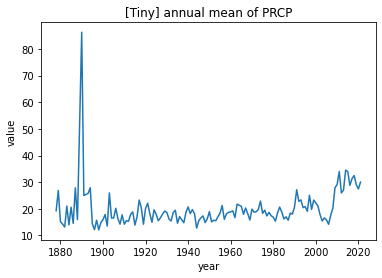

In [9]:
# Plot the results
plt.plot(tiny_prcp.compute().sort_values(by='year'))
plt.xlabel('year')
plt.ylabel('value')
plt.title('[Tiny] annual mean of PRCP')

plt.show()

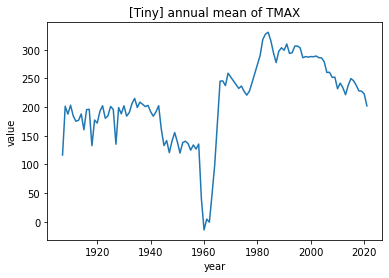

In [10]:
# Plot the results
plt.plot(tiny_tmax.compute().sort_values(by='year'))
plt.xlabel('year')
plt.ylabel('value')
plt.title('[Tiny] annual mean of TMAX')

plt.show()

In [19]:
## saving tmax-tiny.csv files
# tiny_prcp.compute().sort_values(by='year').to_csv('tiny-prcp.csv')

In [20]:
# tiny_tmax.compute().sort_values(by='year').to_csv('tiny-tmax.csv')

### Small

In [11]:
files_small_bags = db.from_sequence(files_small, npartitions=4).map(load_daily)
files_small_bags_flatted = files_small_bags.flatten()

In [12]:
files_small_bags_flatted = files_small_bags_flatted.filter(lambda x : (x['value'] != -9999) & (x['quality']== ' '))

files_small_bags_flatted_prcp = files_small_bags_flatted.filter(lambda x : x['element'] == 'PRCP')
files_small_bags_flatted_tmax = files_small_bags_flatted.filter(lambda x : x['element'] == 'TMAX')

In [13]:
small_prcp = files_small_bags_flatted_prcp.to_dataframe(meta = {'year': int, 'value': int}).groupby('year').mean()
small_prcp = small_prcp.to_delayed()
small_prcp = client.persist(small_prcp)
small_prcp = dd.from_delayed(small_prcp)

# %time small_prcp.compute()
%time small_prcp.compute().sort_values(by='year')

CPU times: user 3.92 ms, sys: 0 ns, total: 3.92 ms
Wall time: 7.25 ms


,value
year,
1850,11.000000
1851,22.676712
1852,25.000000
1853,19.131507
1854,17.610959
...,...
2017,27.436538
2018,29.298194
2019,28.190322


In [14]:
# tmax
small_tmax = files_small_bags_flatted_tmax.to_dataframe(meta = {'year': int, 'value': int}).groupby('year').mean()
small_tmax = small_tmax.to_delayed()
small_tmax = client.persist(small_tmax)
small_tmax = dd.from_delayed(small_tmax)

%time small_tmax.compute().sort_values(by='year')

CPU times: user 4.74 ms, sys: 0 ns, total: 4.74 ms
Wall time: 8.28 ms


,value
year,
1877,139.717391
1878,127.110302
1879,85.651083
1880,93.548564
1881,101.363014
...,...
2017,162.554171
2018,158.338263
2019,157.740272


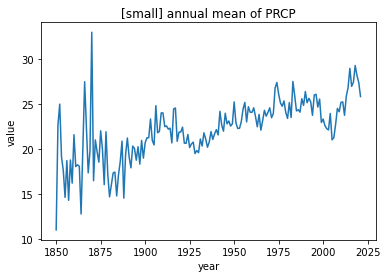

In [15]:
# Plot the results
plt.plot(small_prcp.compute().sort_values(by='year'))
plt.xlabel('year')
plt.ylabel('value')
plt.title('[small] annual mean of PRCP')

plt.show()

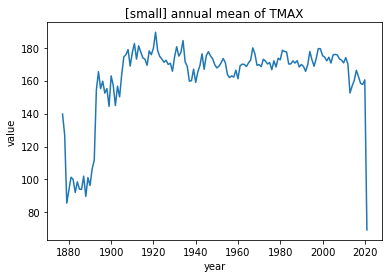

In [16]:
# Plot the results
plt.plot(small_tmax.compute().sort_values(by='year'))
plt.xlabel('year')
plt.ylabel('value')
plt.title('[small] annual mean of TMAX')

plt.show()

In [20]:
## saving tmax-small.csv files
# small_prcp.compute().sort_values(by='year').to_csv('small-prcp.csv')

In [21]:
# small_tmax.compute().sort_values(by='year').to_csv('small-tmax.csv')

### All

### Final result: below conditions applied altogether made an optimized result
- filtered by conditions before converting into dataframe
- using meta when converting into dataframe
- using delayed object
- using client.persist to optimize .compute
- sort later
- increase npartition = 10,000

In [4]:
files_all_bags = db.from_sequence(files_all, npartitions=10000).map(load_daily)
files_all_bags_flatted = files_all_bags.flatten()

In [5]:
files_all_bags_flatted = files_all_bags_flatted.filter(lambda x : (x['value'] != -9999) & (x['quality']== ' '))

files_all_bags_flatted_prcp = files_all_bags_flatted.filter(lambda x : x['element'] == 'PRCP')
files_all_bags_flatted_tmax = files_all_bags_flatted.filter(lambda x : x['element'] == 'TMAX')

In [6]:
all_prcp = files_all_bags_flatted_prcp.to_dataframe(meta = {'year': int, 'value': int}).groupby('year').mean()
all_prcp = all_prcp.to_delayed()
all_prcp = client.persist(all_prcp)
all_prcp = dd.from_delayed(all_prcp)

%time all_prcp.compute().sort_values(by='year')

CPU times: user 3.67 ms, sys: 1.01 ms, total: 4.69 ms
Wall time: 8.25 ms


,value
year,
1781,24.558904
1782,13.712329
1783,17.832877
1784,16.576503
1785,16.169863
...,...
2017,28.086188
2018,28.818076
2019,27.960530


In [7]:
# tmax
all_tmax = files_all_bags_flatted_tmax.to_dataframe(meta={'year': int, 'value': int}).groupby('year').mean()

all_tmax = all_tmax.to_delayed()
all_tmax = client.persist(all_tmax)
all_tmax = dd.from_delayed(all_tmax)

%time all_tmax.compute().sort_values(by='year')

CPU times: user 4.77 ms, sys: 23 µs, total: 4.79 ms
Wall time: 8.09 ms


,value
year,
1763,150.089636
1764,153.592896
1765,150.756906
1766,149.919890
1767,146.078873
...,...
2017,168.188259
2018,164.232468
2019,162.076482


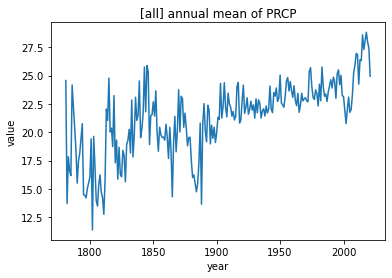

In [21]:
# Plot the results
plt.plot(all_prcp.compute().sort_values(by='year'))
plt.xlabel('year')
plt.ylabel('value')
plt.title('[all] annual mean of PRCP')

plt.show()

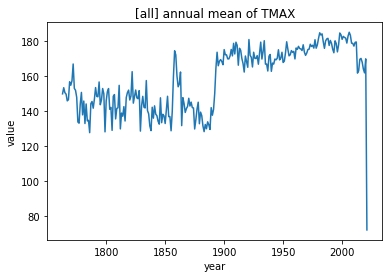

In [22]:
# Plot the results
plt.plot(all_tmax.compute().sort_values(by='year'))
plt.xlabel('year')
plt.ylabel('value')
plt.title('[all] annual mean of TMAX')

plt.show()

In [23]:
## saving tmax-all.csv files
# all_prcp.compute().sort_values(by='year').to_csv('all-prcp.csv')

In [24]:
# all_tmax.compute().sort_values(by='year').to_csv('all-tmax.csv')

## --- Below are trial and errors of optimization ---

### Trial 8 (repartition=10,000) -> success, but didn't optimized the result
- Assuming repartition method might improve the result, I've tried repartition function
- However, it didn't improved the result. Therefore, I've excluded this approach

In [4]:
files_all_bags = db.from_sequence(files_all, npartitions=10000).map(load_daily)
files_all_bags_flatted = files_all_bags.flatten()

In [5]:
files_all_bags_flatted = files_all_bags_flatted.filter(lambda x : (x['value'] != -9999) & (x['quality']== ' '))

files_all_bags_flatted_prcp = files_all_bags_flatted.filter(lambda x : x['element'] == 'PRCP')
files_all_bags_flatted_tmax = files_all_bags_flatted.filter(lambda x : x['element'] == 'TMAX')

In [6]:
all_prcp = files_all_bags_flatted_prcp.to_dataframe(meta = {'year': int, 'value': int}).groupby('year').mean()

all_prcp = all_prcp.repartition(10000)

all_prcp = all_prcp.to_delayed()
all_prcp = client.persist(all_prcp)
all_prcp = dd.from_delayed(all_prcp)

%time all_prcp.compute().sort_values(by='year')

CPU times: user 13 s, sys: 452 ms, total: 13.4 s
Wall time: 22.6 s


,value
year,
1781,24.558904
1782,13.712329
1783,17.832877
1784,16.576503
1785,16.169863
...,...
2017,28.086188
2018,28.818076
2019,27.960530


In [8]:
# tmax
all_tmax = files_all_bags_flatted_tmax.to_dataframe(meta={'year': int, 'value': int}).groupby('year').mean()

all_tmax = all_tmax.repartition(10000)
all_tmax = all_tmax.to_delayed()
all_tmax = client.persist(all_tmax)
all_tmax = dd.from_delayed(all_tmax)

%time all_tmax.compute().sort_values(by='year')

CPU times: user 15.1 s, sys: 408 ms, total: 15.5 s
Wall time: 23.9 s


,value
year,
1763,150.089636
1764,153.592896
1765,150.756906
1766,149.919890
1767,146.078873
...,...
2017,168.188259
2018,164.232468
2019,162.076482


### Trial 7(npartitions=10,000) -> success, final result
- As default npartition is 101, I've increased npartition to 10,000 as it has a huge dataset
- This made an optimizated result(final result)

In [4]:
files_all_bags = db.from_sequence(files_all, npartitions=10000).map(load_daily)
files_all_bags_flatted = files_all_bags.flatten()

In [5]:
files_all_bags_flatted = files_all_bags_flatted.filter(lambda x : (x['value'] != -9999) & (x['quality']== ' '))

files_all_bags_flatted_prcp = files_all_bags_flatted.filter(lambda x : x['element'] == 'PRCP')
files_all_bags_flatted_tmax = files_all_bags_flatted.filter(lambda x : x['element'] == 'TMAX')

In [6]:
all_prcp = files_all_bags_flatted_prcp.to_dataframe(meta = {'year': int, 'value': int}).groupby('year').mean()
all_prcp = all_prcp.to_delayed()
all_prcp = client.persist(all_prcp)
all_prcp = dd.from_delayed(all_prcp)

%time all_prcp.compute().sort_values(by='year')

CPU times: user 3.67 ms, sys: 1.01 ms, total: 4.69 ms
Wall time: 8.25 ms


,value
year,
1781,24.558904
1782,13.712329
1783,17.832877
1784,16.576503
1785,16.169863
...,...
2017,28.086188
2018,28.818076
2019,27.960530


In [7]:
# tmax
all_tmax = files_all_bags_flatted_tmax.to_dataframe(meta={'year': int, 'value': int}).groupby('year').mean()

all_tmax = all_tmax.to_delayed()
all_tmax = client.persist(all_tmax)
all_tmax = dd.from_delayed(all_tmax)

%time all_tmax.compute().sort_values(by='year')

CPU times: user 4.77 ms, sys: 23 µs, total: 4.79 ms
Wall time: 8.09 ms


,value
year,
1763,150.089636
1764,153.592896
1765,150.756906
1766,149.919890
1767,146.078873
...,...
2017,168.188259
2018,164.232468
2019,162.076482


### Trial 6: sort after compute -> success
- sorting after compute will optimize the result, as sorting itself needs extra computation

In [4]:
files_all_bags = db.from_sequence(files_all).map(load_daily)
files_all_bags_flatted = files_all_bags.flatten()

In [5]:
files_all_bags_flatted = files_all_bags_flatted.filter(lambda x : (x['value'] != -9999) & (x['quality']== ' '))

files_all_bags_flatted_prcp = files_all_bags_flatted.filter(lambda x : x['element'] == 'PRCP')
files_all_bags_flatted_tmax = files_all_bags_flatted.filter(lambda x : x['element'] == 'TMAX')

In [6]:
all_prcp = files_all_bags_flatted_prcp.to_dataframe(meta={'year': int, 'value': int}).groupby('year').mean()

all_prcp = all_prcp.to_delayed()
all_prcp = client.persist(all_prcp)
all_prcp = dd.from_delayed(all_prcp)

%time all_prcp.compute().sort_values(by='year')

CPU times: user 4.4 ms, sys: 892 µs, total: 5.29 ms
Wall time: 9.12 ms


,value
year,
1781,24.558904
1782,13.712329
1783,17.832877
1784,16.576503
1785,16.169863
...,...
2017,28.086188
2018,28.818076
2019,27.960530


In [7]:
# tmax
all_tmax = files_all_bags_flatted_tmax.to_dataframe(meta={'year': int, 'value': int}).groupby('year').mean()

all_tmax = all_tmax.to_delayed()
all_tmax = client.persist(all_tmax)
all_tmax = dd.from_delayed(all_tmax)

%time all_tmax.compute().sort_values(by='year')

CPU times: user 4.96 ms, sys: 0 ns, total: 4.96 ms
Wall time: 8.66 ms


,value
year,
1763,150.089636
1764,153.592896
1765,150.756906
1766,149.919890
1767,146.078873
...,...
2017,168.188259
2018,164.232468
2019,162.076482


### Trial 5: using meta -> success
- using meta can make more optimized result, as it pre-defines column data type

In [4]:
files_all_bags = db.from_sequence(files_all).map(load_daily)
files_all_bags_flatted = files_all_bags.flatten()

In [5]:
files_all_bags_flatted = files_all_bags_flatted.filter(lambda x : (x['value'] != -9999) & (x['quality']== ' '))

files_all_bags_flatted_prcp = files_all_bags_flatted.filter(lambda x : x['element'] == 'PRCP')
files_all_bags_flatted_tmax = files_all_bags_flatted.filter(lambda x : x['element'] == 'TMAX')

In [9]:
all_prcp = files_all_bags_flatted_prcp.to_dataframe(meta={'year': int, 'value': int}).groupby('year', sort=True).mean()

all_prcp = all_prcp.to_delayed()
all_prcp = client.persist(all_prcp)
all_prcp = dd.from_delayed(all_prcp)

%time all_prcp.compute()

CPU times: user 5.36 ms, sys: 53 µs, total: 5.42 ms
Wall time: 11.2 ms


,value
year,
1781,24.558904
1782,13.712329
1783,17.832877
1784,16.576503
1785,16.169863
...,...
2017,28.086188
2018,28.818076
2019,27.960530


In [6]:
# tmax
all_tmax = files_all_bags_flatted_tmax.to_dataframe(meta={'year': int, 'value': int}).groupby('year', sort=True).mean()

all_tmax = all_tmax.to_delayed()
all_tmax = client.persist(all_tmax)
all_tmax = dd.from_delayed(all_tmax)

%time all_tmax.compute()

CPU times: user 5.12 ms, sys: 0 ns, total: 5.12 ms
Wall time: 11.3 ms


,value
year,
1763,150.089636
1764,153.592896
1765,150.756906
1766,149.919890
1767,146.078873
...,...
2017,168.188259
2018,164.232468
2019,162.076482


### Trial 4: defining columns when converting into dataframe -> success
- This may happen as we pre-define columns when converting bag into dataframe

In [4]:
files_all_bags = db.from_sequence(files_all).map(load_daily)
files_all_bags_flatted = files_all_bags.flatten()

In [5]:
files_all_bags_flatted = files_all_bags_flatted.filter(lambda x : (x['value'] != -9999) & (x['quality']== ' '))

files_all_bags_flatted_prcp = files_all_bags_flatted.filter(lambda x : x['element'] == 'PRCP')
files_all_bags_flatted_tmax = files_all_bags_flatted.filter(lambda x : x['element'] == 'TMAX')

In [9]:
all_prcp = files_all_bags_flatted_prcp.to_dataframe(columns = ['year', 'value']).groupby('year', sort=True).mean()

all_prcp = all_prcp.to_delayed()
all_prcp = client.persist(all_prcp)
all_prcp = dd.from_delayed(all_prcp)

%time all_prcp.compute()

CPU times: user 4.43 ms, sys: 1.06 ms, total: 5.49 ms
Wall time: 8.48 ms


,value
year,
1781,24.558904
1782,13.712329
1783,17.832877
1784,16.576503
1785,16.169863
...,...
2017,28.086188
2018,28.818076
2019,27.960530


In [6]:
# tmax
all_tmax = files_all_bags_flatted_tmax.to_dataframe(columns = ['year', 'value']).groupby('year', sort=True).mean()

all_tmax = all_tmax.to_delayed()
all_tmax = client.persist(all_tmax)
all_tmax = dd.from_delayed(all_tmax)

%time all_tmax.compute()

CPU times: user 4.4 ms, sys: 1.02 ms, total: 5.42 ms
Wall time: 17.1 ms


,value
year,
1763,150.089636
1764,153.592896
1765,150.756906
1766,149.919890
1767,146.078873
...,...
2017,168.188259
2018,164.232468
2019,162.076482


### Trial 3: using delay object before compute -> fail
- convert bag -> dataframe -> delay -> dataframe should make some progress
- It made some optimized result for 'tiny', 'small' computation
- However, it seems that more methods are needed make 'all' computation work

In [4]:
files_all_bags = db.from_sequence(files_all).map(load_daily)
files_all_bags_flatted = files_all_bags.flatten()

In [5]:
files_all_bags_flatted = files_all_bags_flatted.filter(lambda x : (x['value'] != -9999) & (x['quality']== ' '))

files_all_bags_flatted_prcp = files_all_bags_flatted.filter(lambda x : x['element'] == 'PRCP')
files_all_bags_flatted_tmax = files_all_bags_flatted.filter(lambda x : x['element'] == 'TMAX')

In [6]:
all_prcp = files_all_bags_flatted_prcp.to_dataframe().groupby('year', sort=True)['value'].mean()

all_prcp = all_prcp.to_delayed()
all_prcp = client.persist(all_prcp)
all_prcp = dd.from_delayed(all_prcp)

%time all_prcp.compute()

KilledWorker: ("('filter-lambda-flatten-to_dataframe-0245971ac940477d5a983f9b9011fd92', 32)", <Worker 'tcp://10.32.33.187:35793', name: 5-1, memory: 0, processing: 13>)

### Trial 2: using client.persist before compute -> fail
- This is one of the optimization method in compute
- However, it failed to load the result

In [7]:
files_all_bags = db.from_sequence(files_all).map(load_daily)
files_all_bags_flatted = files_all_bags.flatten()

In [8]:
files_all_bags_flatted = files_all_bags_flatted.filter(lambda x : (x['value'] != -9999) & (x['quality']== ' '))

files_all_bags_flatted_prcp = files_all_bags_flatted.filter(lambda x : x['element'] == 'PRCP')
files_all_bags_flatted_tmax = files_all_bags_flatted.filter(lambda x : x['element'] == 'TMAX')

In [9]:
all_prcp = files_all_bags_flatted_prcp.to_dataframe().groupby('year', sort=True)['value'].mean()
all_prcp = client.persist(all_prcp)
%time all_prcp.compute()

KilledWorker: ("('filter-lambda-flatten-to_dataframe-6dcd85b5cac8f3be33be68a2643892fe', 43)", <Worker 'tcp://10.32.33.46:33761', name: 5-0, memory: 0, processing: 3>)

### (Baseline) Trial 1: using filter at bag, and convert to dataframe -> fail
- While this method all worked well in tiny and small, it failed to compute 'all' dataset

In [4]:
files_all_bags = db.from_sequence(files_all).map(load_daily)
files_all_bags_flatted = files_all_bags.flatten()

In [5]:
files_all_bags_flatted = files_all_bags_flatted.filter(lambda x : (x['value'] != -9999) & (x['quality']== ' '))

files_all_bags_flatted_prcp = files_all_bags_flatted.filter(lambda x : x['element'] == 'PRCP')
files_all_bags_flatted_tmax = files_all_bags_flatted.filter(lambda x : x['element'] == 'TMAX')

In [6]:
all_prcp = files_all_bags_flatted_prcp.to_dataframe().groupby('year', sort=True)['value'].mean()

%time all_prcp.compute()

distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/ext3/miniconda3/lib/python3.8/site-packages/distributed/core.py", line 493, in handle_comm
    result = handler(comm, **msg)
  File "/ext3/miniconda3/lib/python3.8/site-packages/distributed/scheduler.py", line 2196, in heartbeat_worker
    ws._executing = {
  File "/ext3/miniconda3/lib/python3.8/site-packages/distributed/scheduler.py", line 2197, in <dictcomp>
    self.tasks[key]: duration for key, duration in executing.items()
KeyError: "('filter-lambda-flatten-to_dataframe-0245971ac940477d5a983f9b9011fd92', 90)"


KilledWorker: ("('filter-lambda-flatten-to_dataframe-0245971ac940477d5a983f9b9011fd92', 31)", <Worker 'tcp://10.32.33.140:37033', name: 3-1, memory: 0, processing: 5>)

distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/ext3/miniconda3/lib/python3.8/site-packages/distributed/core.py", line 493, in handle_comm
    result = handler(comm, **msg)
  File "/ext3/miniconda3/lib/python3.8/site-packages/distributed/scheduler.py", line 2196, in heartbeat_worker
    ws._executing = {
  File "/ext3/miniconda3/lib/python3.8/site-packages/distributed/scheduler.py", line 2197, in <dictcomp>
    self.tasks[key]: duration for key, duration in executing.items()
KeyError: "('filter-lambda-flatten-to_dataframe-0245971ac940477d5a983f9b9011fd92', 13)"
distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/ext3/miniconda3/lib/python3.8/site-packages/distributed/core.py", line 493, in handle_comm
    result = handler(comm, **msg)
  File "/ext3/miniconda3/lib/python3.8/site-packages/distributed/scheduler.py", line 2196, in heartbeat_worker
    ws._exec